In [1]:
import pandas as pd
import numpy as np
from taxi_trip import transform
from pandarallel import pandarallel

In [2]:
directorio_parquet = 'datasets/taxi_trip/yellow_tripdata_2018-01.parquet'
directorio_Location = 'datasets/taxi_zone_lookup.csv'
directorio_calendar = 'datasets/calendar.csv'

In [3]:
#funcion para calcular outliers
def outliers_obt(data, columna,cuartial1,cuartil2,valoriqr=1.5):
    ##calculamos los cuartiles 
    Q1 = data[columna].quantile(float(cuartial1))
    #print('Primer Cuartile', Q1)
    Q3 = data[columna].quantile(float(cuartil2))
    #print('Tercer Cuartile',Q3)
    IQR = Q3 - Q1
    #print('Rango intercuartile', IQR)

    ##calculamos los bigotes superior e inferior
    BI = (Q1 - valoriqr * IQR)
    #print('bigote Inferior \n', BI)
    BS = (Q3 + valoriqr * IQR)
    #print('bigote superior \n', BS)

    ##obtenemos una nueva tabla sin los outliers
    ubi_sin_out = data[(data[columna] >= BI) & (data[columna] <= BS)]
    return ubi_sin_out




In [4]:

#crear dataframe
df = pd.read_parquet(directorio_parquet)
df_Taxi_zone = pd.read_csv(directorio_Location)
calendar = pd.read_csv(directorio_calendar, sep=';')
print('dataset cargados')
 ##NORMALIZACION
#('---------------------------------OUTLIERS---------------------------')
df=outliers_obt(df,'total_amount','0.25','0.75',valoriqr=4.5)
df=outliers_obt(df,'improvement_surcharge','0.25','0.75',valoriqr=4.5)
df=outliers_obt(df,'tip_amount','0.25','0.75',valoriqr=2)
df=outliers_obt(df,'mta_tax','0.25','0.75',valoriqr=1.5)
df=outliers_obt(df,'extra','0.25','0.75',valoriqr=1.5)
df=outliers_obt(df,'fare_amount','0.25','0.75',valoriqr=4.5)
df=outliers_obt(df,'trip_distance','0.25','0.75',valoriqr=3)
df=outliers_obt(df,'tpep_dropoff_datetime','0.25','0.75',valoriqr=1.5)
print('outlayers dropeados')


dataset cargados
outlayers dropeados


In [5]:
#-----------------------------------------------------------------------------------------------------
## Partir data set para rendimiento
#df = df.iloc[:100000]
#-----------------------------------------------------------------------------------------------------
## NORMALIZACION
# copia del df
df_changes =df.copy()
# reemplazo valores nulos 
df_changes['congestion_surcharge'].fillna(0.0, inplace=True)
df_changes['airport_fee'].fillna(0.0, inplace=True)
# resto las columnas que no usaremos o dropeamos
df_changes['total_amount_1'] = df_changes.total_amount - df_changes.tolls_amount - df_changes.congestion_surcharge - df_changes.airport_fee
df_changes.drop(['congestion_surcharge','airport_fee'], axis=1, inplace=True)
df_changes['Travel_time'] = df_changes.tpep_dropoff_datetime - df_changes.tpep_pickup_datetime
# creo columna de location
df_changes['LocationID']=df_changes['PULocationID']
# DF Taxi_zone
# Reemplazo valores nulos
df_Taxi_zone['Zone'].fillna('Not specified',inplace=True)
df_Taxi_zone['service_zone'].fillna('Not specified',inplace=True)
# realizo merge para tener todo en un solo df
df_changes= df_changes.merge(df_Taxi_zone, how='left', on='LocationID')
print('1/4')


1/4


In [6]:
# reseteo el index para renemobarlo y cambiarle el nombre a IdTaxis
df_changes.reset_index(inplace=True)
df_changes.rename(columns={'index':'IdTaxis_2018'}, inplace=True)
#normalizo todos los nombres de los ID 
df_changes.rename(columns={ 'VendorID':'IdVendor','RatecodeID':'IdRatecode','PULocationID':'IdPULocation','DOLocationID':'IdDOLocation',
                            'payment_type':'IdPayment_type','LocationID':'IdLocation'},inplace=True)
# en la columna de tpep_pickup_datetime hay fechas mayores al mes de Enero, realizo un drop
df_changes.drop(df_changes[df_changes['tpep_pickup_datetime'] > '2018-02-01'].index, inplace = True)
# Creo tabla de Hechos "taxi_trip_2018"
taxi_trip_2018 = df_changes[:][[   'IdTaxis_2018','IdVendor','tpep_pickup_datetime','tpep_dropoff_datetime','Travel_time','IdRatecode','IdPULocation'
                                ,'IdDOLocation','IdPayment_type','Borough','fare_amount','extra','mta_tax','tip_amount','improvement_surcharge','total_amount_1']]
print('2/4')
## CREACION TABLAS DE DIMENCION
vendor={    1:'Creative Mobile Technologies, LLC',
            2:'VeriFone Inc'}
vendor = pd.DataFrame([[key, vendor[key]] for key in vendor.keys()], columns=['IdVendor', 'Name_vendor'])
Ratecode={  1:'Tarifa estándar',
            2:'jfk',
            3:'nuevaark',
            4:'nassau o westchester',
            5:'tarifa negociada',
            6:'paseo en grupo'}
Ratecode = pd.DataFrame([[key, Ratecode[key]] for key in Ratecode.keys()], columns=['IdRatecode', 'Name_ratecode'])
payment={   1:'tarjeta de crédito',
            2:'efectivo',
            3:'sin cargo',
            4:'disputa',
            5:'desconocido',
            6:'viaje anulado'}
payment = pd.DataFrame([[key, payment[key]] for key in payment.keys()], columns=['IdPayment_type', 'Payment_type'])
Borough_dic = [ {'IdBorough':1,'Borough':'EWR','Latitude':40.6895314,'Longitude':-74.17446239999998},
                {'IdBorough':2,'Borough':'Queens','Latitude':40.742054,'Longitude':-73.769417},
                {'IdBorough':3,'Borough':'Bronx','Latitude':40.837048,'Longitude':-73.865433},
                {'IdBorough':4,'Borough':'Manhattan','Latitude':40.776676,'Longitude':-73.971321},
                {'IdBorough':5,'Borough':'Staten Island','Latitude':40.579021,'Longitude':-74.151535},
                {'IdBorough':6,'Borough':'Brooklyn','Latitude':40.650002,'Longitude':-73.949997}]
Borough = pd.DataFrame(Borough_dic)
# Funcion para relacionar los indices de una columna con otra
def algo(params):
    if params == 'EWR':
        return 1
    if params == 'Queens':
        return 2
    if params == 'Bronx':
        return 3
    if params == 'Manhattan':
        return 4
    if params == 'Staten Island':
        return 5
    if params == 'Brooklyn':
        return 6
    else:
        return params
print('3/4')


2/4
3/4


In [7]:
pandarallel.initialize()
# subescribo los valores del df "df_Taxi_zone" de la columna "borough" y le aplico un nuevo valores con la funcion creada arriba
df_Taxi_zone.Borough = df_Taxi_zone.Borough.parallel_apply(algo)
# renombro la columna 
df_Taxi_zone.rename(columns={'Borough':'IdBorough'}, inplace=True)
# realizo un drop de la columna "service_zone"
df_Taxi_zone.drop('service_zone',axis=1 ,inplace=True)
## tabla de dimencion "Location"
Location = df_Taxi_zone.copy()
##normalizo la columna "Date" del "calendario" con la forma "AAAA-MM-DD"
#calendar["Date"] = pd.to_datetime(calendar["date"])
## renombro columna id de "calendario"
#calendar.rename(columns={'id':'IdCalendar'}, inplace=True)
## organizo las columnas 
#calendar = calendar.reindex(columns=['IdCalendar','Date','year','week','day','hour'])
# Funcion para relacionar los indices de una columna con otra para la tabla taxi_trip_2018
#def algo1(params):
#    try:
#        return Borough.IdBorough[Borough.Borough== params].iloc[0]
#    except:
#        return 7
# subescribo los valores del df "taxi_trip_2018" de la columna "borough" y le aplico un nuevo valores con la funcion creada arriba
taxi_trip_2018.Borough = taxi_trip_2018.Borough.parallel_apply(algo)     #1)----------------------------------------------
# Cambio el nombre de la columna "Borough" 
taxi_trip_2018.rename(columns={'Borough':'IdBorough'}, inplace=True)

#lista_table=[Borough, Location,Ratecode,payment,vendor, calendar, taxi_trip_2018] 
lista_table = []
lista_table.append(taxi_trip_2018)
#print(type(lista_table))
#print(type(lista_table[0]))
#print(lista_table[0].head())
print('4/4')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
4/4


In [8]:
df_Taxi_zone.head()

,LocationID,IdBorough,Zone
0,1,1,Newark Airport
1,2,2,Jamaica Bay
2,3,3,Allerton/Pelham Gardens
3,4,4,Alphabet City
4,5,5,Arden Heights


In [9]:
Borough.IdBorough.unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [10]:
df_Taxi_zone = df_Taxi_zone.merge(Borough, how= 'left', on='IdBorough')
df_Taxi_zone.drop(columns=['Zone','Latitude', 'Longitude'], inplace=True)
df_Taxi_zone

,LocationID,IdBorough,Borough
0,1,1,EWR
1,2,2,Queens
2,3,3,Bronx
3,4,4,Manhattan
4,5,5,Staten Island
...,...,...,...
260,261,4,Manhattan
261,262,4,Manhattan
262,263,4,Manhattan
263,264,Unknown,NaN


In [11]:
df_Taxi_zone.shape

(265, 3)

In [12]:
df_Taxi_zone.head()

,LocationID,IdBorough,Borough
0,1,1,EWR
1,2,2,Queens
2,3,3,Bronx
3,4,4,Manhattan
4,5,5,Staten Island


In [13]:
def zone2borough(param):
    return df_Taxi_zone.IdBorough[df_Taxi_zone.LocationID == param].iloc[0]
    

In [14]:
df_Taxi_zone.Borough[df_Taxi_zone.IdBorough == 'Unknown'] = 'Unknown'

C:\Users\exort\AppData\Local\Temp\ipykernel_19540\1654309336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Taxi_zone.Borough[df_Taxi_zone.IdBorough == 'Unknown'] = 'Unknown'


In [15]:
taxi_trip_2018.shape

(7955121, 16)

In [16]:
taxi_trip_2018 = taxi_trip_2018.merge(df_Taxi_zone, how = 'left', right_on = 'LocationID', left_on = 'IdPULocation')
#taxi_trip_2018.drop(columns= ['IdPULocation', 'LocationID'], inplace=True)
taxi_trip_2018.rename(columns={'Borough' : 'boroughPU'}, inplace=True)

In [17]:
taxi_trip_2018.head()

,IdTaxis_2018,IdVendor,tpep_pickup_datetime,tpep_dropoff_datetime,Travel_time,IdRatecode,IdPULocation,IdDOLocation,IdPayment_type,IdBorough_x,fare_amount,extra,mta_tax,tip_amount,improvement_surcharge,total_amount_1,LocationID,IdBorough_y,boroughPU
0,0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,0 days 00:03:18,1,41,24,2,4,4.5,0.5,0.5,0.00,0.3,5.80,41,4,Manhattan
1,1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,0 days 00:18:10,1,239,140,2,4,14.0,0.5,0.5,0.00,0.3,15.30,239,4,Manhattan
2,2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,0 days 00:05:55,1,262,141,1,4,6.0,0.5,0.5,1.00,0.3,8.30,262,4,Manhattan
3,3,1,2018-01-01 00:09:18,2018-01-01 00:27:06,0 days 00:17:48,1,246,239,1,4,12.5,0.5,0.5,2.75,0.3,16.55,246,4,Manhattan
4,4,1,2018-01-01 00:29:29,2018-01-01 00:32:48,0 days 00:03:19,1,143,143,2,4,4.5,0.5,0.5,0.00,0.3,5.80,143,4,Manhattan


In [18]:
# marge entre columnas bla bla bla
taxi_trip_2018 = taxi_trip_2018.merge(df_Taxi_zone, how = 'left', right_on = 'LocationID', left_on = 'IdDOLocation')
#taxi_trip_2018.drop(columns= ['IdDOLocation', 'LocationID'], inplace=True)
taxi_trip_2018.rename(columns={'Borough':'boroughDO'}, inplace=True)

In [19]:
taxi_trip_2018.shape

(7955121, 22)

In [20]:
taxi = taxi_trip_2018[['boroughPU', 'boroughDO']]

In [22]:
taxi.shape

(7955121, 2)

In [20]:
taxi.head()

,boroughPU,boroughDO
0,Manhattan,Manhattan
1,Manhattan,Manhattan
2,Manhattan,Manhattan
3,Manhattan,Manhattan
4,Manhattan,Manhattan


In [23]:
taxi.boroughPU.unique()

array(['Manhattan', 'Queens', 'Bronx', 'Brooklyn', 'Unknown',
       'Staten Island', 'EWR'], dtype=object)

In [24]:
taxi.groupby('boroughPU').size()

boroughPU
Bronx               6303
Brooklyn           89050
EWR                   41
Manhattan        7597916
Queens            123146
Staten Island         89
Unknown           138576
dtype: int64

In [25]:
s = (taxi.groupby(['boroughDO', 'boroughPU']).size()).unstack()

In [42]:
s

boroughPU,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,Unknown
boroughDO,,,,,,,
Bronx,4594.0,NaN,NaN,14696.0,474.0,NaN,79.0
Brooklyn,NaN,64473.0,NaN,154492.0,5656.0,5.0,574.0
EWR,NaN,NaN,38.0,2.0,NaN,NaN,7.0
Manhattan,1628.0,21888.0,NaN,7337223.0,20980.0,1.0,16765.0
Queens,51.0,2430.0,NaN,82742.0,94736.0,NaN,1134.0
Staten Island,NaN,2.0,NaN,NaN,NaN,83.0,3.0
Unknown,30.0,257.0,3.0,8761.0,1300.0,NaN,120014.0


In [28]:
most_PU = s.sum().sum()
most_PU

7955121.0

In [29]:
most_DO = s.sum(axis=1)
most_DO

boroughDO
Bronx              19843.0
Brooklyn          225200.0
EWR                   47.0
Manhattan        7398485.0
Queens            181093.0
Staten Island         88.0
Unknown           130365.0
dtype: float64

<AxesSubplot:title={'center':'Trips from Queens to'}, xlabel='boroughDO'>

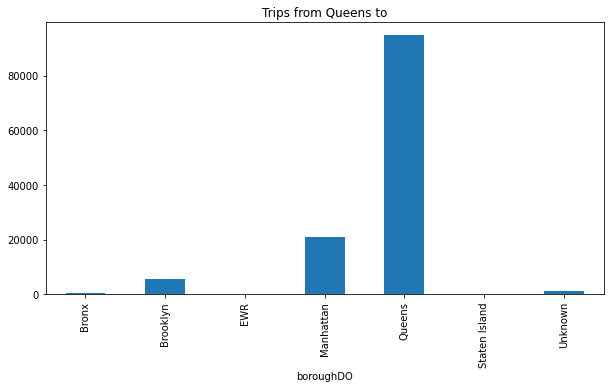

In [30]:
s.Queens.plot(kind = 'bar', title = 'Trips from Queens to', figsize = (10,5))

<AxesSubplot:title={'center':'Trips to Brooklyn from'}, xlabel='boroughPU'>

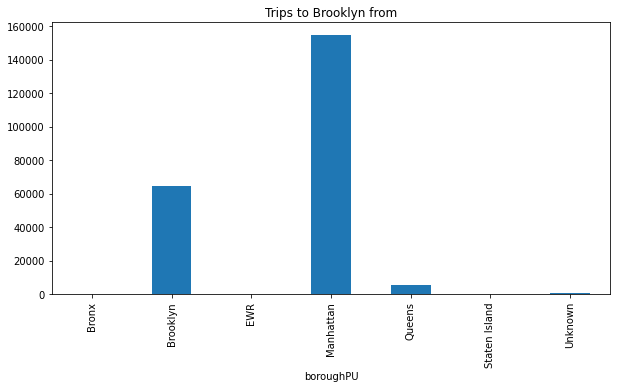

In [31]:
s.loc['Brooklyn'].plot(kind = 'bar', title = 'Trips to Brooklyn from', figsize = (10,5))

In [32]:
z = s.fillna(0)

In [33]:
z.drop(columns=['EWR'], inplace=True)

In [34]:
z.drop(['EWR'], axis=0, inplace=True)

In [35]:
z

boroughPU,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Unknown
boroughDO,,,,,,
Bronx,4594.0,0.0,14696.0,474.0,0.0,79.0
Brooklyn,0.0,64473.0,154492.0,5656.0,5.0,574.0
Manhattan,1628.0,21888.0,7337223.0,20980.0,1.0,16765.0
Queens,51.0,2430.0,82742.0,94736.0,0.0,1134.0
Staten Island,0.0,2.0,0.0,0.0,83.0,3.0
Unknown,30.0,257.0,8761.0,1300.0,0.0,120014.0


In [36]:
z.index

Index(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Unknown'], dtype='object', name='boroughDO')

Trips to borough (on chart) from (boroughs on legends)

In [41]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
# Initialize a figure with ff.create_table(table_data)
fig = ff.create_table(z.reset_index(), height_constant=20,)

# Add graph data
teams = ['Montréal Canadiens', 'Dallas Stars', 'NY Rangers',
         'Boston Bruins', 'Chicago Blackhawks', 'Ottawa Senators']
bronx = z.loc['Bronx']
brooklyn = z.loc['Brooklyn']
Queens = z.loc['Queens'] 
manhattan = z.loc['Manhattan']
stataten = z.loc['Staten Island']
unknown = z.loc['Unknown']
#
# Make traces for graph
trace1 = go.Bar(x=z.columns, y=brooklyn, xaxis='x2', yaxis='y2',
                marker=dict(color='#0099ff'),
                name='Brooklyn')
trace2 = go.Bar(x=z.columns, y=bronx, xaxis='x2', yaxis='y2',
                marker=dict(color='#404040'),
                name='Bronx')
trace3 = go.Bar(x=z.columns, y=Queens, xaxis='x2', yaxis='y2',
                marker=dict(color='#FF0000'),
                name='Queens')
trace4 = go.Bar(x=z.columns, y=manhattan, xaxis='x2', yaxis='y2',
                marker=dict(color='#FF00FF'),
                name='Manhattan')
trace5 = go.Bar(x=z.columns, y=stataten, xaxis='x2', yaxis='y2',
                marker=dict(color='#2EFE2E'),
                name='Staten')
trace6 = go.Bar(x=z.columns, y=unknown, xaxis='x2', yaxis='y2',
                marker=dict(color='#00FFFF'),
                name='Unknown')

# Add trace data to figure
fig.add_traces([trace1, trace2, trace3, trace4, trace5, trace6])

# initialize xaxis2 and yaxis2
fig['layout']['xaxis2'] = {}
fig['layout']['yaxis2'] = {}

# Edit layout for subplots
fig.layout.yaxis.update({'domain': [0, .45]})
fig.layout.yaxis2.update({'domain': [.6, 1]})

# The graph's yaxis2 MUST BE anchored to the graph's xaxis2 and vice versa
fig.layout.yaxis2.update({'anchor': 'x2'})
fig.layout.xaxis2.update({'anchor': 'y2'})
fig.layout.yaxis2.update({'title': 'Trips'})

# Update the margins to add a title and see graph x-labels.
fig.layout.margin.update({'t':75, 'l':50})
fig.layout.update({'title': 'Trips to boroughs (on chart) from (borough on legends)'})

# Update the height because adding a graph vertically will interact with
# the plot height calculated for the table
fig.layout.update({'height':800})

# Plot!
fig.show()

'Trips from borough (on chart) to (boroughs on legends)

In [43]:
# Initialize a figure with ff.create_table(table_data)
fig = ff.create_table(z.reset_index(), height_constant=20)

# Add graph data
bronx = z['Bronx']
brooklyn = z['Brooklyn']
Queens = z['Queens'] 
manhattan = z['Manhattan']
stataten = z['Staten Island']
unknown = z['Unknown']
#
# Make traces for graph
trace1 = go.Bar(x=z.columns, y=brooklyn, xaxis='x2', yaxis='y2',
                marker=dict(color='#0099ff'),
                name='Brooklyn')
trace2 = go.Bar(x=z.columns, y=bronx, xaxis='x2', yaxis='y2',
                marker=dict(color='#404040'),
                name='Bronx')
trace3 = go.Bar(x=z.columns, y=Queens, xaxis='x2', yaxis='y2',
                marker=dict(color='#FF0000'),
                name='Queens')
trace4 = go.Bar(x=z.columns, y=manhattan, xaxis='x2', yaxis='y2',
                marker=dict(color='#FF00FF'),
                name='Manhattan')
trace5 = go.Bar(x=z.columns, y=stataten, xaxis='x2', yaxis='y2',
                marker=dict(color='#2EFE2E'),
                name='Staten')
trace6 = go.Bar(x=z.columns, y=unknown, xaxis='x2', yaxis='y2',
                marker=dict(color='#00FFFF'),
                name='Unknown')

# Add trace data to figure
fig.add_traces([trace1, trace2, trace3, trace4, trace5, trace6])

# initialize xaxis2 and yaxis2
fig['layout']['xaxis2'] = {}
fig['layout']['yaxis2'] = {}

# Edit layout for subplots
fig.layout.yaxis.update({'domain': [0, .45]})
fig.layout.yaxis2.update({'domain': [.6, 1]})

# The graph's yaxis2 MUST BE anchored to the graph's xaxis2 and vice versa
fig.layout.yaxis2.update({'anchor': 'x2'})
fig.layout.xaxis2.update({'anchor': 'y2'})
fig.layout.yaxis2.update({'title': 'Trips'})

# Update the margins to add a title and see graph x-labels.
fig.layout.margin.update({'t':75, 'l':50})
fig.layout.update({'title': 'Trips from boroughs (on chart) to (borough on legends)'})

# Update the height because adding a graph vertically will interact with
# the plot height calculated for the table
fig.layout.update({'height':800})

# Plot!
fig.show()